<a href="https://www.kaggle.com/code/faiqueali/titanic-survival-clusters-voting-ensemble?scriptVersionId=237747054" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [16]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Constants

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_id = test["PassengerId"]
data = pd.concat([train, test], sort=False)

# Feature Engineering

In [6]:
def extract_title(name):
    title_search = re.search(" ([A-Za-z]+)\.", name)
    return title_search.group(1) if title_search else ""

def process_data(df):
    df["Title"] = df["Name"].apply(extract_title)
    df["Title"] = df["Title"].replace(["Lady", "Countess", "Capt", "Col",
                                       "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"],
                                      "Rare")
    df["Title"] = df["Title"].replace("Mlle", "Miss").replace("Ms", "Miss").replace("Mme", "Mrs")
    
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Sex"] = df["Sex"].fillna(-1).astype(int)  # fill NaNs with -1 or any sentinel

    
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = 1  # initialize to yes/1
    df.loc[df["FamilySize"] > 1, "IsAlone"] = 0  # fix chained assignment

    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])
    df["Embarked"] = LabelEncoder().fit_transform(df["Embarked"])
    
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    
    df["Cabin"] = df["Cabin"].fillna("U")
    df["Deck"] = df["Cabin"].apply(lambda x: x[0])
    df["Deck"] = LabelEncoder().fit_transform(df["Deck"])
    
    df["TicketPrefix"] = df["Ticket"].apply(lambda x: re.sub(r'[^A-Za-z]', '', x) if not x.isdigit() else 'NONE')
    df["TicketPrefix"] = LabelEncoder().fit_transform(df["TicketPrefix"])
    
    df["Title"] = LabelEncoder().fit_transform(df["Title"])
    df["HasCabin"] = df["Cabin"].apply(lambda x: 0 if x == "U" else 1)

    return df


data = process_data(data)

# Data Imputation

In [7]:
features_for_impute = ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked", "Title", "FamilySize"]
imputer = KNNImputer(n_neighbors=5)
data["Age"] = imputer.fit_transform(data[features_for_impute + ["Age"]])[:, -1]

# Cluster Feature as Creativity Twist

In [9]:
kmeans_features = ["Age", "Fare", "Pclass", "Sex", "FamilySize", "Title"]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data["ClusterGroup"] = kmeans.fit_predict(data[kmeans_features])

# Train/Test Set

In [11]:
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin", "Survived"]
X = data.loc[data["Survived"].notnull()].drop(columns=drop_cols)
y = data.loc[data["Survived"].notnull()]["Survived"].astype(int)
X_test_final = data.loc[data["Survived"].isnull()].drop(columns=drop_cols)

# Voting Ensemble

In [12]:
model1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model2 = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=1)
model3 = LGBMClassifier(random_state=1)

ensemble = VotingClassifier(
    estimators=[("rf", model1), ("xgb", model2), ("lgb", model3)],
    voting="soft"
)

ensemble.fit(X, y)
preds = ensemble.predict(X_test_final)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


# Visuals

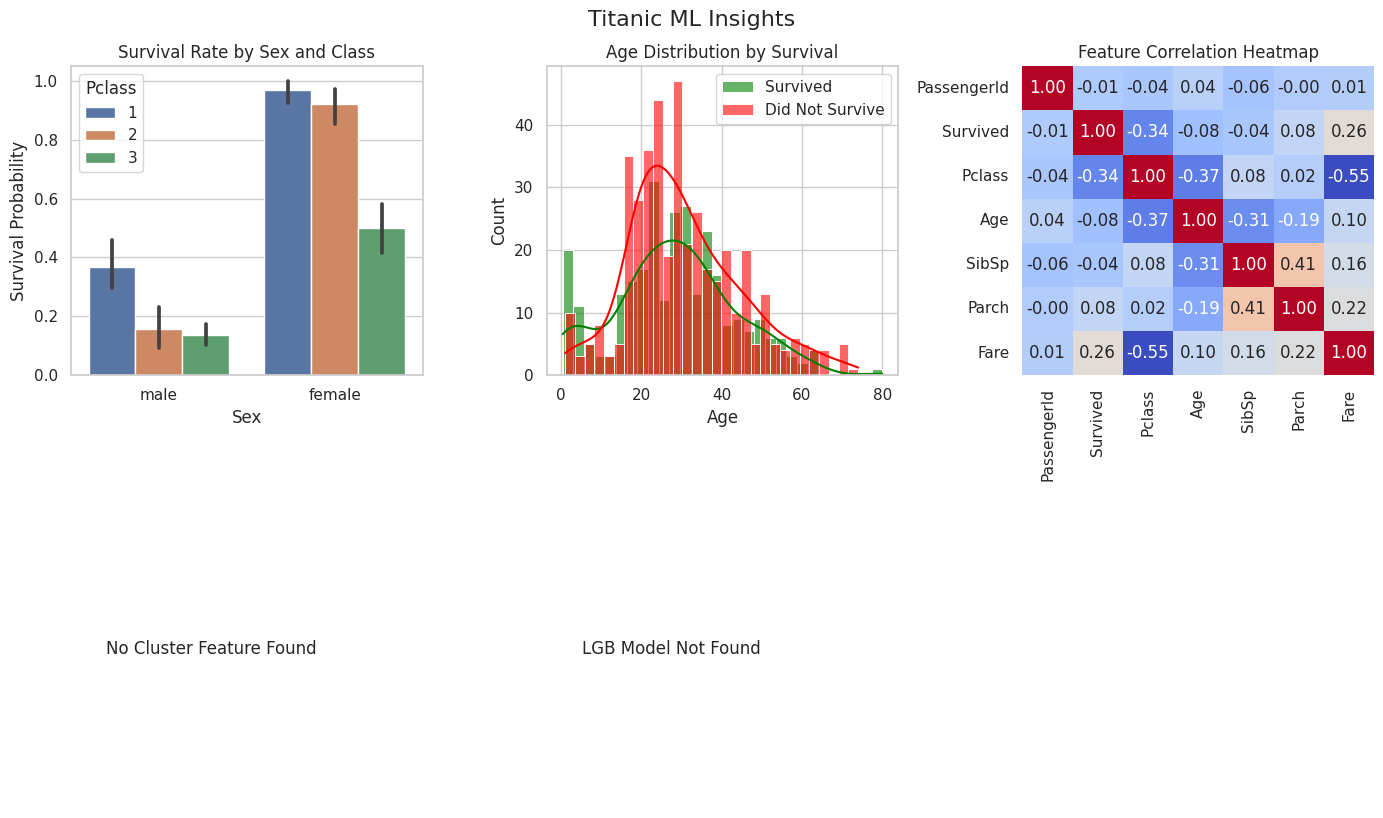

In [17]:
# Set seaborn style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Plot 1: Survival Rate by Sex and Pclass
plt.subplot(2, 3, 1)
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train)
plt.title("Survival Rate by Sex and Class")
plt.ylabel("Survival Probability")

# Plot 2: Age Distribution with Survival Overlay
plt.subplot(2, 3, 2)
sns.histplot(train[train['Survived']==1]['Age'], kde=True, color="green", label="Survived", bins=30, alpha=0.6)
sns.histplot(train[train['Survived']==0]['Age'], kde=True, color="red", label="Did Not Survive", bins=30, alpha=0.6)
plt.legend()
plt.title("Age Distribution by Survival")

# Plot 3: Correlation Heatmap
plt.subplot(2, 3, 3)
corr = train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")

# Plot 4: Cluster Distribution by Survival
plt.subplot(2, 3, 4)
if 'Cluster' in train.columns:
    sns.countplot(x='Cluster', hue='Survived', data=train)
    plt.title("KMeans Cluster vs Survival")
else:
    plt.text(0.1, 0.5, 'No Cluster Feature Found', fontsize=12)
    plt.axis('off')

# Plot 5: LightGBM Feature Importance
plt.subplot(2, 3, 5)
try:
    lgb.plot_importance(clf.named_estimators_['lgb'], max_num_features=10, height=0.4)
    plt.title("LGB Feature Importances")
except:
    plt.text(0.1, 0.5, 'LGB Model Not Found', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Titanic ML Insights", fontsize=16, y=1.02)
plt.show()

# Prepare .csv for submission

In [18]:
submission = pd.DataFrame({
    "PassengerId": passenger_id,
    "Survived": preds.astype(int)
})
submission.to_csv("creative_titanic_submission.csv", index=False)